In [16]:

import sys
from pathlib import Path

project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))


import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from pathlib import Path
from data_processing.data_ingestion import load_days
from data_generation.utils import deliver_original_data

# Plot settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [17]:
# Adjust as needed
MODEL_PATH = project_root / Path("model_registry/model_day_5.json")

# Load model
model = xgb.XGBClassifier()
model.load_model(str(MODEL_PATH))

# Load data
# df = load_days(23, 23)
df = deliver_original_data()

# Basic check
df["Class"].value_counts(normalize=True)


Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.30      1.00      0.46       492

    accuracy                           1.00    284807
   macro avg       0.65      1.00      0.73    284807
weighted avg       1.00      1.00      1.00    284807

ROC AUC: 0.9997943245132467


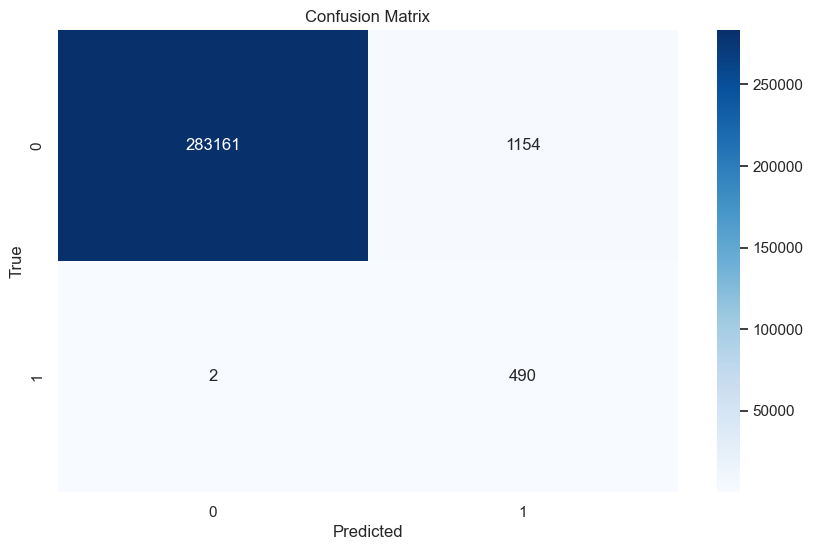

In [19]:
cols_to_drop = [x for x in ["Class", "Day", "PerturbationScheme", "dt"] if x in df.columns]
X = df.drop(columns=cols_to_drop)
y = df["Class"]

y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:, 1]

print(classification_report(y, y_pred))
print("ROC AUC:", roc_auc_score(y, y_prob))

# Confusion matrix
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


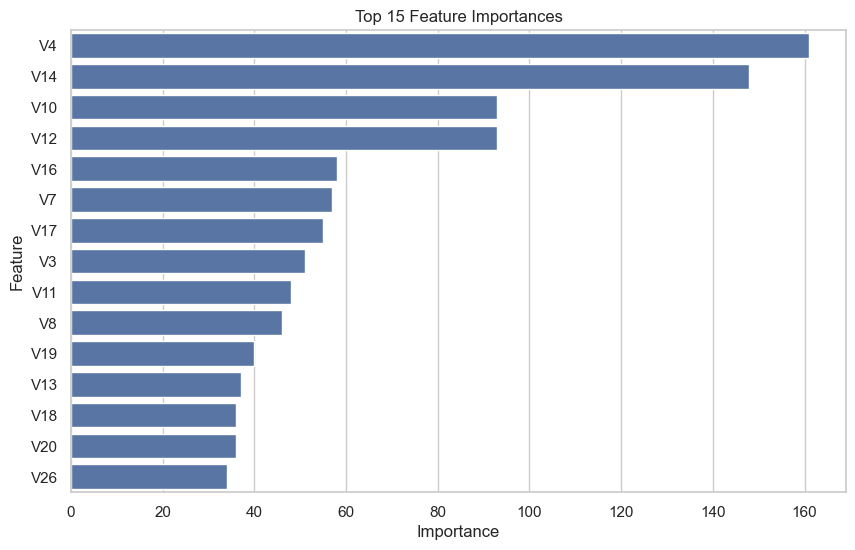

In [14]:
booster = model.get_booster()
importance = booster.get_score(importance_type="weight")
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

sns.barplot(x="Importance", y="Feature", data=importance_df.head(15))
plt.title("Top 15 Feature Importances")
plt.show()


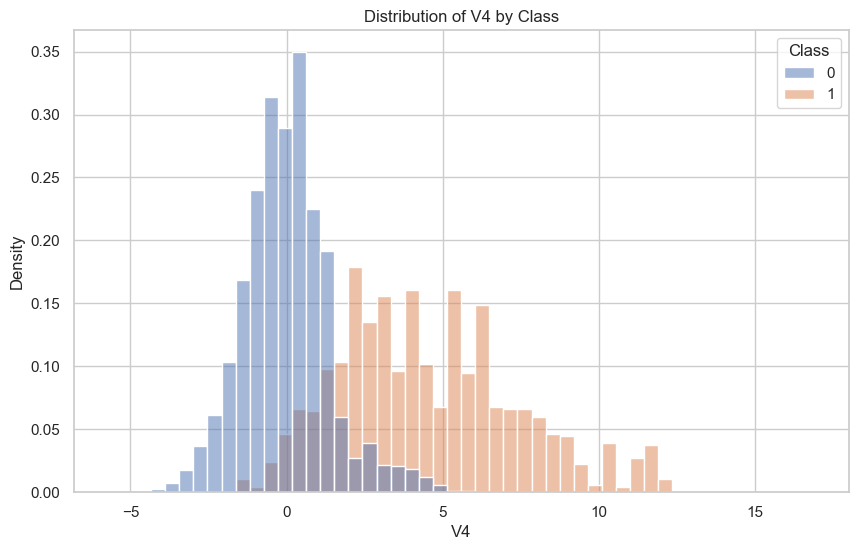

In [15]:
top_feature = importance_df.iloc[0]["Feature"]

sns.histplot(data=df, x=top_feature, hue="Class", bins=50, stat="density", common_norm=False)
plt.title(f"Distribution of {top_feature} by Class")
plt.show()
